# Introduction

The data analyzed were collected between the 06/16/2020 and the 08/07/2020.

This camera is located place general de gaulle in Mouans Sartoux in France

This camera is equipped with image recognition to count pedestrians, cars, bicycles, trucks

This implies periods of inactivity, at night for example.

> &#171; The question is to find what knowledge can be extracted from this data in order to provide the relevant information to users. These users can be pedestrians, drivers but also actors of the municipalities, the town hall, etc... &#187;

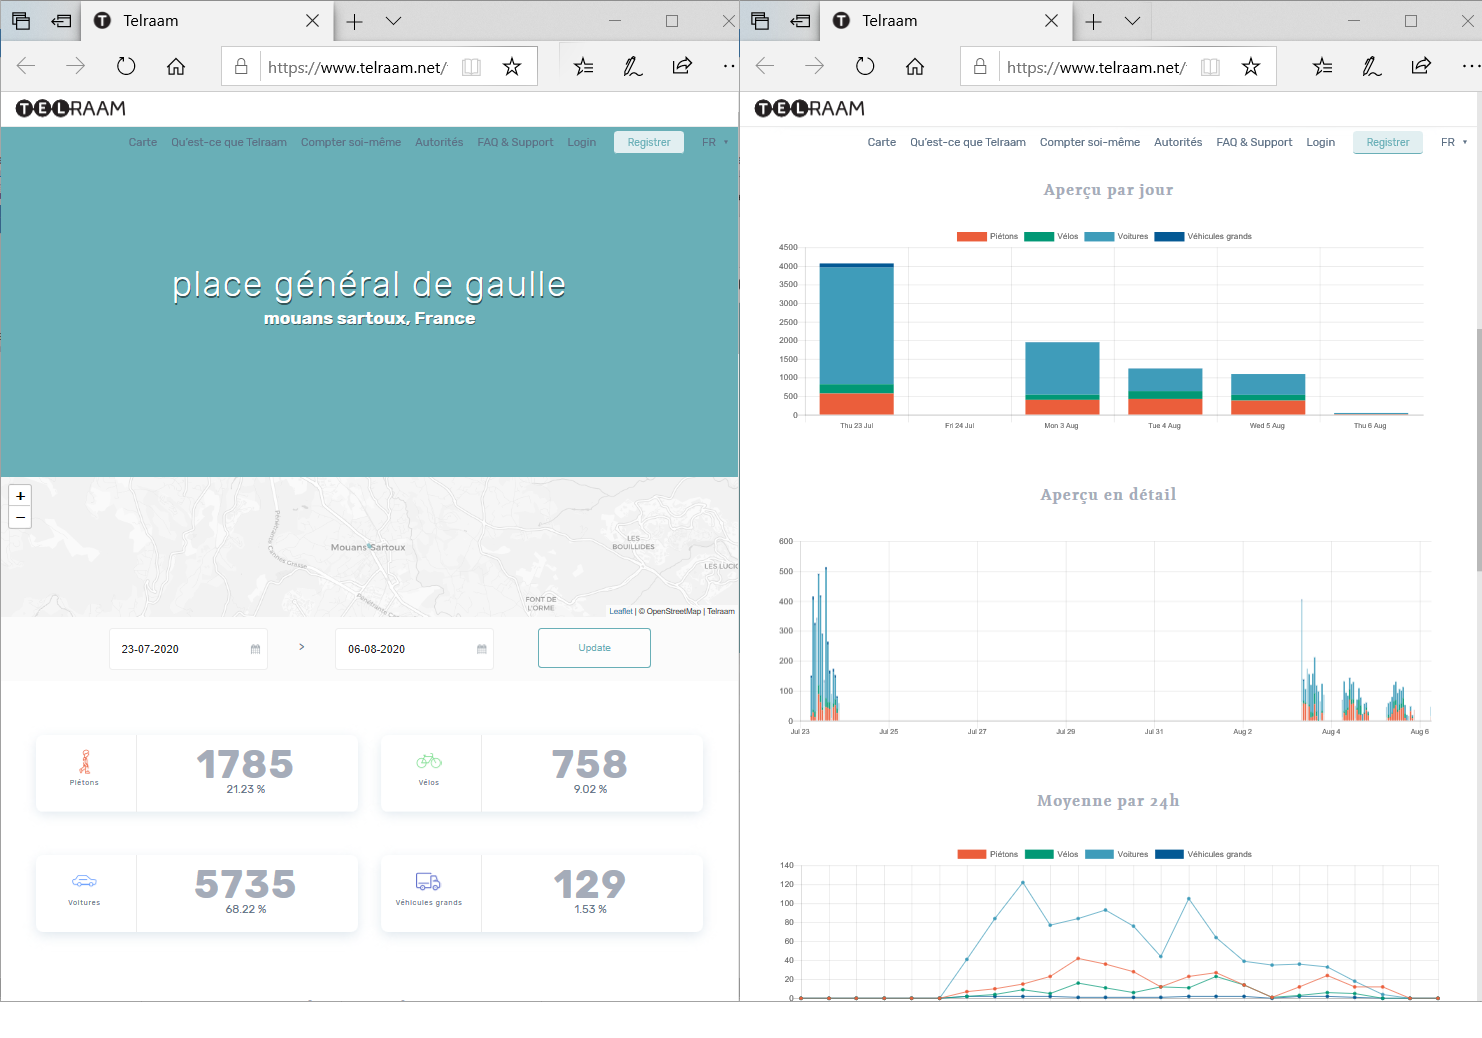


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pickle
import math
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
# Global setting
plt.style.use('seaborn')
file = "/kaggle/input/traffic-counting-using-cameras/telraam.csv"

### Utility functions used in this notebook

In [2]:
# Describe Data
def describeData(data):
    print("shape = {}".format(data.shape))
    description = data.describe().T
    description["isNull"] = data.isnull().sum()
    print(description)
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return math.sqrt(mean_squared_error(actual, predicted))

# Columns description

Each hour the camera records the following data:

- Timestamp : ['time','id','timezone']
- Percentage of camera activity : ['pct_up']
- Counting of pedestrians, cars, bicycles, trucks (total, left and right of the street)
['pedestrian','bike','car','lorry','pedestrian_lft','bike_lft','car_lft','lorry_lft','pedestrian_rgt','bike_rgt','car_rgt','lorry_rgt']
- Histogram of car speeds for the intervals [0-10 [[10-20 [[20- 30 [..... [70 and more [
['car_speed_00','car_speed_10','car_speed_20','car_speed_30','car_speed_40','car_speed_50','car_speed_60','car_speed_70']

# Load the data

In [3]:
# Load the data
##########################################
df = pd.read_csv(file, parse_dates = False, header = None,sep=',')
df.columns=['time','id','timezone','pct_up','pedestrian','bike','car','lorry','pedestrian_lft','bike_lft','car_lft','lorry_lft','pedestrian_rgt','bike_rgt','car_rgt','lorry_rgt','car_speed_00','car_speed_10','car_speed_20','car_speed_30','car_speed_40','car_speed_50','car_speed_60','car_speed_70']
df['time'] = pd.to_datetime(df['time'],errors='coerce',utc=True)  
df['time'] = df['time'].fillna(method = 'ffill')
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')
df.head(5)
#describeData(df)

There are 971 rows and 24 columns


,time,id,timezone,pct_up,pedestrian,bike,car,lorry,pedestrian_lft,bike_lft,...,car_rgt,lorry_rgt,car_speed_00,car_speed_10,car_speed_20,car_speed_30,car_speed_40,car_speed_50,car_speed_60,car_speed_70
0,2020-06-11 16:00:00+00:00,9000000411,Europe/Paris,0.09,0.0,0.0,24.0,0.0,0.0,24.0,...,0.0,0.0,12.0,12.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-06-16 10:00:00+00:00,9000000411,Europe/Paris,0.10,21.0,63.0,682.0,0.0,0.0,388.0,...,294.0,0.0,210.0,242.0,158.0,53.0,11.0,11.0,NaN,NaN
2,2020-06-16 11:00:00+00:00,9000000411,Europe/Paris,0.76,19.0,56.0,747.0,0.0,12.0,392.0,...,355.0,0.0,131.0,230.0,266.0,92.0,11.0,4.0,4.0,12.0
3,2020-06-16 12:00:00+00:00,9000000411,Europe/Paris,0.63,22.0,45.0,539.0,0.0,11.0,159.0,...,380.0,0.0,171.0,92.0,168.0,68.0,15.0,13.0,8.0,8.0
4,2020-06-16 14:00:00+00:00,9000000411,Europe/Paris,0.42,36.0,125.0,820.0,0.0,12.0,553.0,...,267.0,0.0,322.0,365.0,102.0,15.0,8.0,5.0,3.0,5.0


## Reindexing the data

The camera does not count continuously, there are periods of inactivity.
So the data are reindexed in order to have a record every hour.

There is a big step between the first row and the second (2020-06-11 16:00:00+00:00 to 2020-06-16 10:00:00+00:00), so we skip this first row


In [4]:
# Skip the first row
########################################### 
minDate = '2020-06-16 00:00:00+00'
df = df.loc[df['time']>minDate]

# Reindex the data
########################################### 
df.set_index(['time'],drop=False,inplace=True)
all_freq = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(all_freq)
df['timezone'].fillna('Europe/Paris',inplace=True)
df['time'] = df.index
df['localtime']=df.time.map(lambda t: t.tz_convert(tz = 'Europe/Paris'))
df['dayofweek'] = df['localtime'].dt.dayofweek
df['day'] = df['localtime'].dt.day
df['hour'] = df['localtime'].dt.hour

## Filling Missing Values
With reindexing, we have to fill NaN values. New columns, adjust_#column#, are created where NaN values are replaced by the mean at the same hour and the same day of week. Once it's done,all NaN are replaced by zero. So if we sum the original columns, the counts are OK.

* original columns : car, bike, ... can be used for counting
* adjust_#column# can be used for time series analysis.

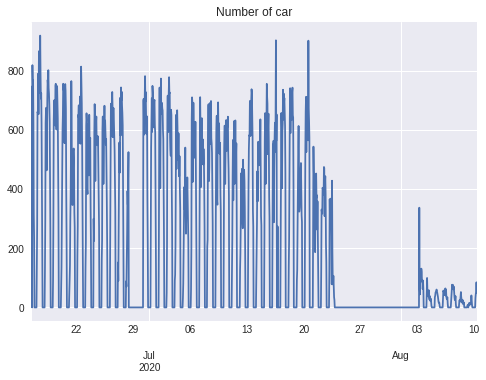

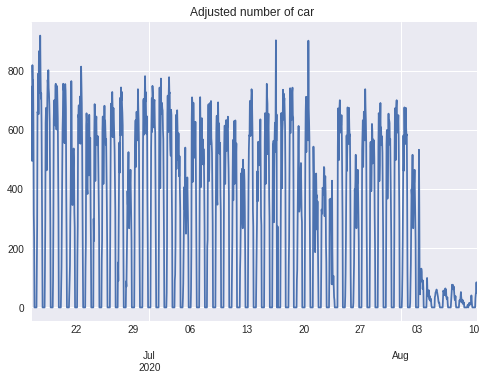

In [5]:
# Fill missing values
###########################################
for col in ['car','pedestrian','lorry','bike','pedestrian_lft','bike_lft','car_lft','lorry_lft','pedestrian_rgt','bike_rgt','car_rgt','lorry_rgt']:
    df['adjust_'+col] = df.groupby(['dayofweek','hour'])[col].transform(lambda x: x.fillna(x.median()))
    df[col].fillna(0,inplace=True)
df.fillna(0,inplace=True)

# See adjusted data versus row data
###########################################
df['car'].plot(title='Number of car')
plt.show()
df['adjust_car'].plot(title='Adjusted number of car ')
plt.show()

# Exploratory data analysis

## Estimate the average speed

> &#171; From the data of the histogram of car speeds, we can do a rough estimation of the average speed over the time. &#187;

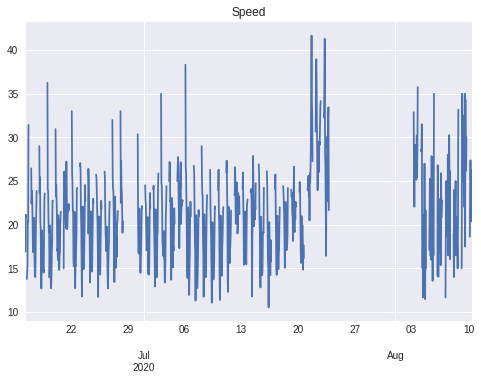

In [6]:
# Estimate the average speed
###########################################
df['speed']=df['car_speed_00']*5+df['car_speed_10']*15+df['car_speed_20']*25+df['car_speed_30']*35+df['car_speed_40']*45+df['car_speed_50']*55+df['car_speed_60']*65+df['car_speed_70']*75
df['speed'] = df['speed'] / (df['car_speed_00']+df['car_speed_10']+df['car_speed_20']+df['car_speed_30']+df['car_speed_40']+df['car_speed_50']+df['car_speed_60']+df['car_speed_70'])
df['speed'].plot(title='Speed')
plt.show()

## Balance between right and left
> &#171; We can also be interested in which direction and at what time of the day is the street more busy, by comparing the count of cars on the right and on the left. &#187;

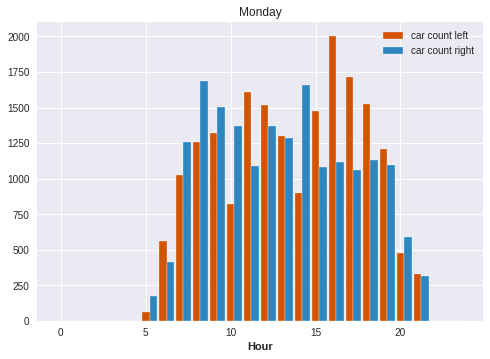

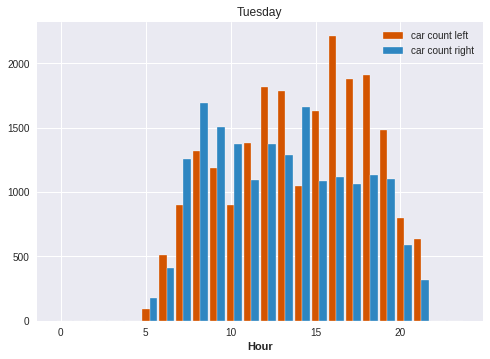

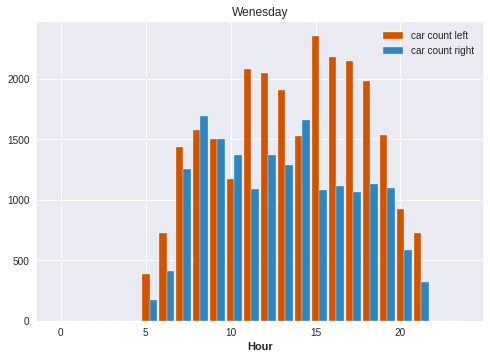

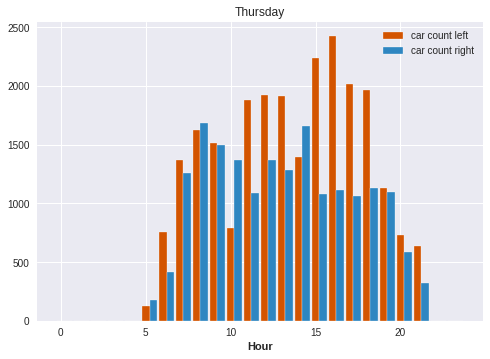

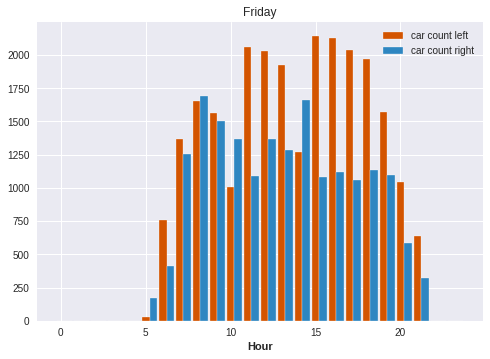

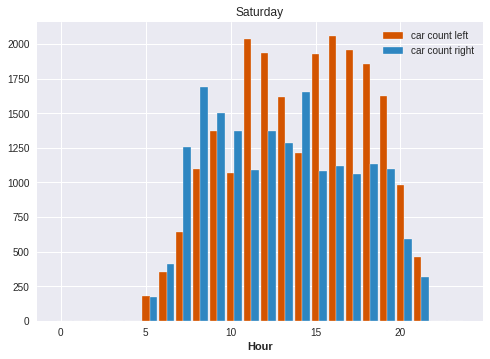

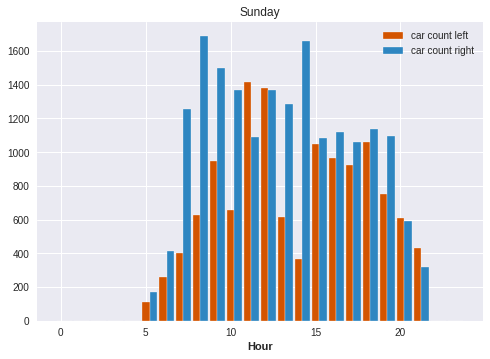

In [7]:
left = pd.pivot_table(df, index="hour", values=['car_lft'],columns=['dayofweek'], aggfunc=np.sum,margins=False,dropna=False)
right = pd.pivot_table(df, index="hour", values=['car_rgt'],columns=['dayofweek'], aggfunc=np.sum,margins=False,dropna=False)
left.columns = ['Monday','Tuesday','Wenesday','Thursday','Friday','Saturday','Sunday']
right.columns = ['Monday','Tuesday','Wenesday','Thursday','Friday','Saturday','Sunday']

barWidth = 0.45

for day in ['Monday','Tuesday','Wenesday','Thursday','Friday','Saturday','Sunday']:
    r1 = np.arange(len(left[day]))
    r2 = [x + barWidth for x in r1]
    plt.bar(r1, left[day], color='#d35400', width=barWidth, edgecolor='white', label='car count left')
    plt.bar(r2, right['Monday'], color='#2e86c1', width=barWidth, edgecolor='white', label='car count right')
    plt.xlabel('Hour', fontweight='bold')
    plt.legend()
    plt.title(day)
    plt.show()

# Average daily trends

> &#171; The idea is to group measures by hour and weekday in order to have daily trends. &#187;

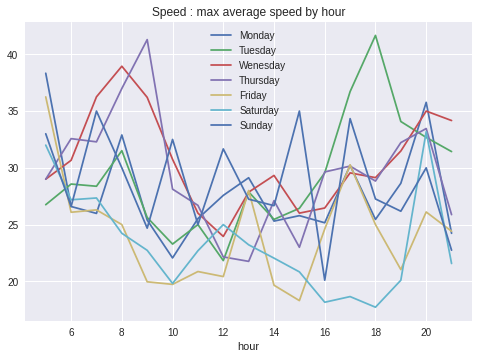

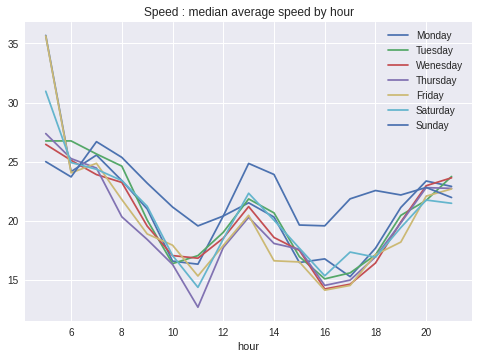

In [8]:
# max / median average speed by hour
###########################################
result = pd.pivot_table(df, index="hour", values=['speed'],columns=['dayofweek'], aggfunc=np.max,margins=False,dropna=False)
result.columns = ['Monday','Tuesday','Wenesday','Thursday','Friday','Saturday','Sunday']
result.plot(title='{} : max average speed by hour'.format('Speed'))
plt.show()

result = pd.pivot_table(df, index="hour", values=['speed'],columns=['dayofweek'], aggfunc=np.median,margins=False,dropna=False)
result.columns = ['Monday','Tuesday','Wenesday','Thursday','Friday','Saturday','Sunday']
result.plot(title='{} : median average speed by hour'.format('Speed'))
plt.show()

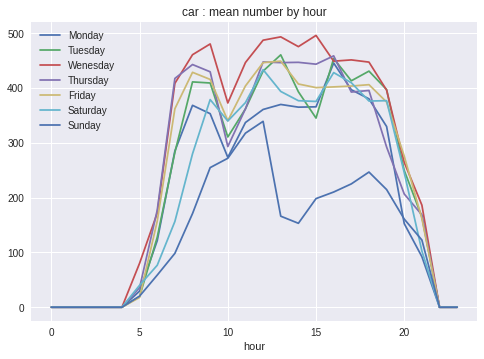

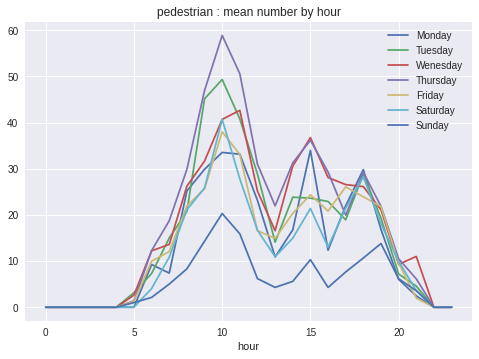

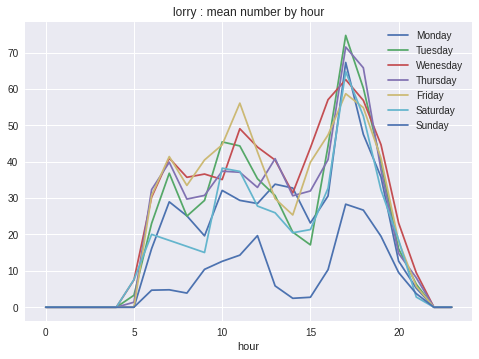

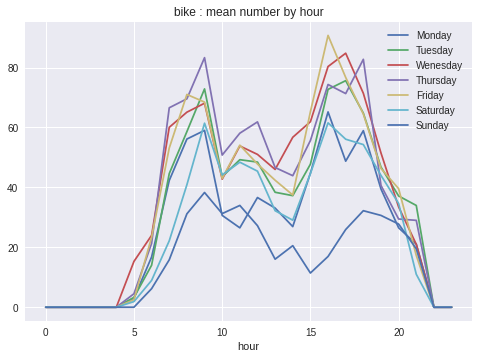

In [9]:
# Mean number by hour
###########################################
for col in ['car','pedestrian','lorry','bike']:
    result = pd.pivot_table(df, index="hour", values=[col],columns=['dayofweek'], aggfunc=np.mean,margins=False,dropna=False)
    result.columns = ['Monday','Tuesday','Wenesday','Thursday','Friday','Saturday','Sunday']
    result.plot(title='{} : mean number by hour'.format(col))
    plt.show()

# Prediction of future flows

> &#171; In view of count observations there is a pattern of daily data.
The idea is to generate from a series of counts, for example car counts, two days in advance to see if we can capture this structure.&#187;

> &#171; On the graph below we see that the data is hieratic from 07/23. There is not enough data to know if this is normal, the activity in August would be very low, or if there is a sensing anomaly. To resolve this point, we would need data for at least one year. &#187;

3 models are tested :
- SARIMA
- ExponentialSmoothing
- LSTM

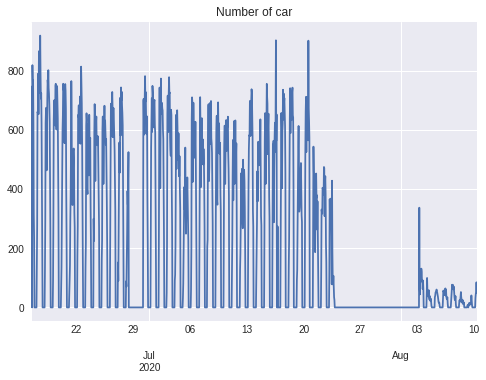

In [10]:
df['car'].plot(title='Number of car')
plt.show()

### Decomposition with the function seasonal_decompose of statsmodels
**This is a naive decomposition.**
It's just to illustrate the decomposition:  
* a base level
* a trend
* a saisonality
* a noise

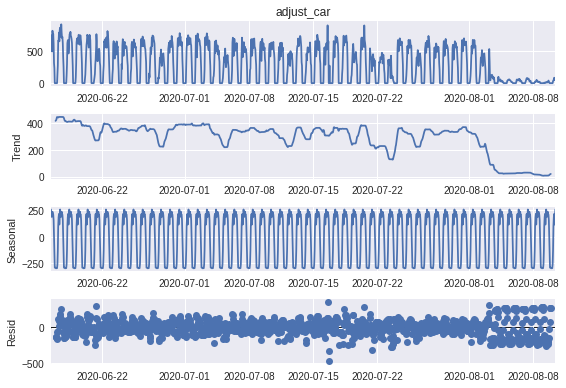

In [11]:
# Decomposition
###########################################
 
d=sm.tsa.seasonal_decompose(df.adjust_car,period=24)
figure = d.plot()
plt.show()

In [15]:
# Select a window of time with clean data 
###########################################

minDate = '2020-06-16 10:00:00+00'
maxDate = '2020-07-21 00:00:00+00'

# Select a window of time with clean data 
# AND
# Split train and test
###########################################
train = df.adjust_car.loc[df.index<'2020-07-19 00:00:00+00'].copy()
test = df.adjust_car.loc[(df.index>='2020-07-19 00:00:00+00')&(df.index<'2020-07-21 00:00:00+00')].copy().iloc[:48]
train_and_test = pd.concat([train,test])
print(train.shape)
print(test.shape)

(782,)
(48,)


## SARIMA

How to configure a SARIMA(p,d,q)(P,D,Q) ?
- Plotting ACF, PACF, etc... OR
- You can use function auto_arima from pmdarima that automatically discover the optimal order for an ARIMA model.

This function auto_arima is time consuming and the model is big (553Mo), so we've ran it once and kept the result :
`order=(1,0,0), seasonal_order=(2,1,0,24)`
```
import pmdarima as pm
grid_model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',
                          max_p=4, max_q=4, m=24,
                          start_P=0, seasonal=True,
                          d=0, D=1, trace=True,
                          error_action='ignore',  
                          suppress_war*n*ings=True, 
                          stepwise=True)
```

In [17]:
# SARIMA
###########################################
model = sm.tsa.statespace.SARIMAX(train, trend='n', order=(1,0,0), seasonal_order=(2,1,0,24))
model_sarima = model.fit()
print(model_sarima.summary())

                                     SARIMAX Results                                      
Dep. Variable:                         adjust_car   No. Observations:                  782
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 24)   Log Likelihood               -4438.848
Date:                            Tue, 11 Aug 2020   AIC                           8885.697
Time:                                    09:53:17   BIC                           8904.220
Sample:                                06-16-2020   HQIC                          8892.830
                                     - 07-18-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6463      0.022     29.982      0.000       0.604       0.689
ar.S.L24      -0.5412      0.021   

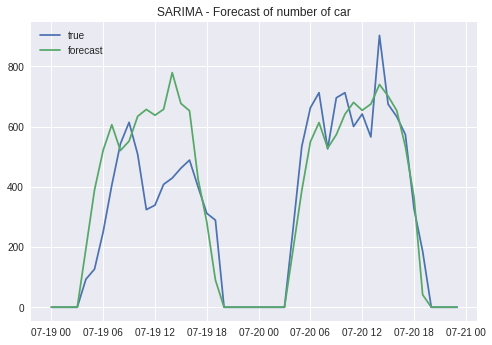

133.22233193204906


In [18]:
forecast_sarima = model_sarima.predict(start = test.index[0], end= test.index[-1], dynamic= True) 
plt.plot(test,label="true")
plt.plot(forecast_sarima,label="forecast")
plt.legend(loc='upper left')
plt.title("SARIMA - Forecast of number of car")
plt.show()

# root mean squared error or rmse
print(measure_rmse(test, forecast_sarima))

## ExponentialSmoothing

In [19]:
# ExponentialSmoothing
###########################################

from statsmodels.tsa.api import ExponentialSmoothing
model_exp = ExponentialSmoothing(train.values, trend='add', seasonal='add', seasonal_periods=24).fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


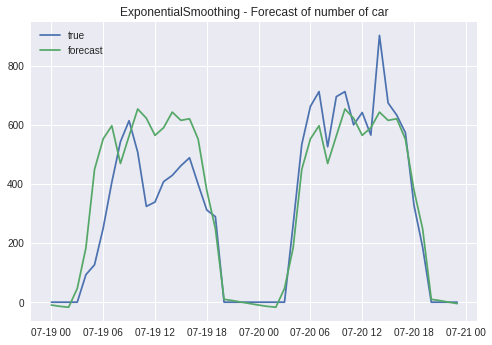

121.92693224038598


In [20]:
forecast_exp = model_exp.forecast(len(test))
forecast_exp = pd.DataFrame(data=forecast_exp,index=test.index)
plt.plot(test,label="true")
plt.plot(test.index,forecast_exp,label="forecast")
plt.legend(loc='upper left')
plt.title("ExponentialSmoothing - Forecast of number of car")
plt.show()

# root mean squared error or rmse
print(measure_rmse(test, forecast_exp))

Train shape = (782, 1)
All shape = (830, 1)
nan values ? False
X shape = (772, 10, 1)
y shape = (772, 1)
Epoch 1/50
11/11 [==============================] - 0s 31ms/step - loss: 0.2067 - val_loss: 0.1907
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.1779 - val_loss: 0.1665
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.1541 - val_loss: 0.1452
Epoch 4/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1311 - val_loss: 0.1242
Epoch 5/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1086 - val_loss: 0.1042
Epoch 6/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0876 - val_loss: 0.0860
Epoch 7/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0695 - val_loss: 0.0705
Epoch 8/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0540 - val_loss: 0.0556
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.0402 - val_loss: 0.0412
Epoch 10/50


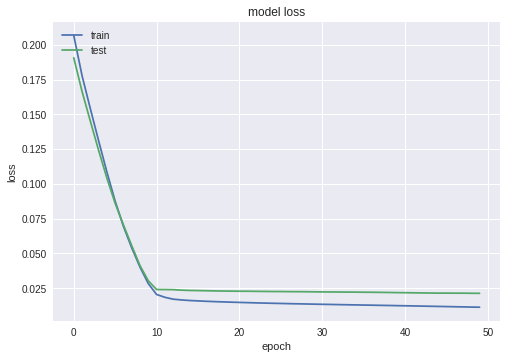

In [21]:
# LSTM
###########################################

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential


# Window size = number of previous values to predict the next value
WINDOW_SIZE = 10

train_serie = train.values.reshape(-1, 1)
all_serie = train_and_test.values.reshape(-1, 1)

#  MinMaxScaler
scaler = MinMaxScaler()
scaled_all_serie = scaler.fit_transform(all_serie)
scaled_train_serie = scaler.transform(train_serie)                     
#scaled_close = scaled_close[~np.isnan(scaled_close)]
#scaled_close = scaled_close.reshape(-1, 1)
print("Train shape = {}".format(scaled_train_serie.shape))
print("All shape = {}".format(scaled_all_serie.shape))
print("nan values ? {}".format(np.isnan(scaled_train_serie).any()))

def generateSequence(sequence,backward):
    X, y = list(), list()
    for i in range(sequence.shape[0]-backward):
        seq_x, seq_y = sequence[i:i+backward], sequence[i+backward]
        X.append(seq_x)
        y.append(seq_y)
    X=np.array(X)
    y=np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X,y
    
X,y = generateSequence(scaled_train_serie,WINDOW_SIZE)
print("X shape = {}".format(X.shape))
print("y shape = {}".format(y.shape))


model = Sequential()
model.add(LSTM(12, activation='relu', input_shape=(WINDOW_SIZE, 1)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))


#  Compile
model.compile(
    loss='mse', 
    optimizer='adam'
)

BATCH_SIZE = 64

#  Compile
history = model.fit(
    X, 
    y, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



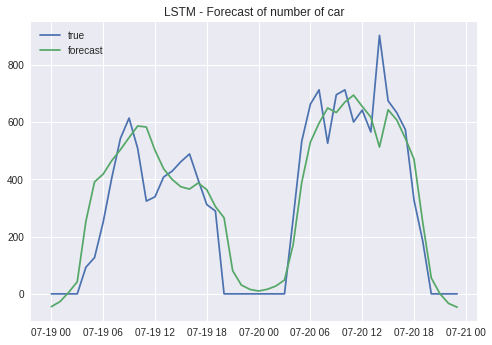

114.15276420162749


In [22]:
X,y = generateSequence(scaled_all_serie,WINDOW_SIZE)
y_predicted = model.predict(X)
y_inverse = scaler.inverse_transform(y)
y_predicted_inverse = scaler.inverse_transform(y_predicted)

forecast_lstm = y_predicted_inverse[-48:].ravel()
plt.plot(test,label="true")
plt.plot(test.index,forecast_lstm,label="forecast")
plt.legend(loc='upper left')
plt.title("LSTM - Forecast of number of car")
plt.show()

# root mean squared error or rmse
print(measure_rmse(test, forecast_lstm))

## Comparison

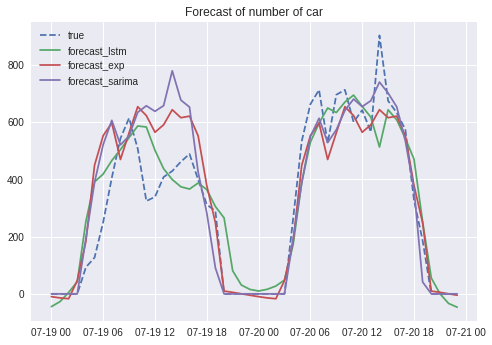

root mean squared error of SARIMA model     = 133.22233193204906
root mean squared error of EXP SMOOTH model = 121.92693224038598
root mean squared error of LSTM model       = 114.15276420162749


In [24]:
## Comparison
plt.plot(test,label="true",linestyle='dashed')
plt.plot(test.index,forecast_lstm,label="forecast_lstm")
plt.plot(test.index,forecast_exp,label="forecast_exp")
plt.plot(test.index,forecast_sarima,label="forecast_sarima")
plt.legend(loc='upper left')
plt.title("Forecast of number of car")
plt.show()

# root mean squared error or rmse
print("root mean squared error of SARIMA model     = {}".format(measure_rmse(test, forecast_sarima)))
print("root mean squared error of EXP SMOOTH model = {}".format(measure_rmse(test, forecast_exp)))
print("root mean squared error of LSTM model       = {}".format(measure_rmse(test, forecast_lstm)))

# Conclusion

> &#171;These traffic counts generated by a camera equipped with image recognition can indeed generate daily trends and flow predictions.&#187;

> &#171;However the results should be much more reliable if the historical data were sufficient to observe all the seasonality in these series, more than 1 year.&#187;

> &#171;The LTSM algorithm that predicts one or more future values from a window into the past would be more reliable.&#187;

> &#171;And with the help of SARIMA or EXP_SMOO, more data in the future could be generated to capture trends.
Finally with more data, we could create sub-series that have very similar daily patterns to make targeted predictive models: working Mondays, Sundays and holidays etc.&#187;

**So, we are going to publish more data from this camera in a few month, and try again**